# deseq2 pipeline in rpy2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import uuid
import pylab as plt
import matplotlib
from IPython.display import display, HTML, Image

import numpy as np
import pandas as pd
    
%matplotlib inline

Load test data

In [3]:
count_data = pd.read_pickle('../static/data/debugging/data_df.p')
count_data = count_data.drop('gene_id', axis=1)
count_data.head()

,HK1cnt,HK2cnt,HK3cnt,INF2cnt,INF3cnt,INF4cnt,M01cnt,M02cnt,M03cnt
gene_pk,,,,,,,,,
ENSMUSG00000000001,4390,4003,5739,3005,3674,2221,4255,4587,3927
ENSMUSG00000000028,44,47,57,43,46,36,60,91,57
ENSMUSG00000000031,0,0,0,0,1,0,0,0,0
ENSMUSG00000000037,2,0,3,0,0,0,4,0,0
ENSMUSG00000000049,0,1,1,0,0,3,0,2,3


In [4]:
col_data = pd.read_pickle('../static/data/debugging/design_df.p')
col_data

,group
sample,
HK1cnt,HK
HK2cnt,HK
HK3cnt,HK
INF2cnt,INFEC
INF3cnt,INFEC
INF4cnt,INFEC
M01cnt,UN
M02cnt,UN
M03cnt,UN


Run DESeq2

In [5]:
from rpy2.robjects.packages import importr
from rpy2 import robjects
from rpy2.robjects import Formula
from rpy2.robjects import pandas2ri
pandas2ri.activate()

deseq = importr('DESeq2')    
grdevices = importr('grDevices')

In [6]:
def to_pd_df(r_df):
    pd_df = pandas2ri.ri2py_dataframe(r_df)
    pd_df.index = r_df.rownames
    return pd_df

In [7]:
def run_deseq(count_data, col_data, keep_threshold, case, control):
    design = Formula("~ group")
    dds = deseq.DESeqDataSetFromMatrix(countData=count_data, colData=col_data, design=design)
    sv = robjects.StrVector(col_data['group'].values)
    condition = robjects.FactorVector(sv)
    runs = col_data.index
    rstring = """
        function(dds, condition, runs, keepThreshold, case, control) {
            # collapse technical replicates
            dds$condition <- condition
            dds$condition <- relevel(dds$condition, ref=control) # set control    
            dds$sample <- runs 
            dds$run <- runs        
            ddsColl <- collapseReplicates(dds, dds$sample, dds$run) 
            # count filter
            keep <- rowSums(counts(ddsColl)) >= keepThreshold
            ddsColl <- ddsColl[keep,]
            # run DESeq2 analysis
            ddsAnalysis <- DESeq(dds)
            res <- results(ddsAnalysis, contrast=c("group", control, case))
            resOrdered <- res[order(res$padj),]  # sort by p-adjusted values
            df = as.data.frame(resOrdered)
            rld <- as.data.frame(assay(rlog(dds, blind=FALSE)))
            list(df, rld, resOrdered)
        }
    """
    rfunc = robjects.r(rstring)
    results = rfunc(dds, condition, runs, keep_threshold, case, control)
    pd_df = to_pd_df(results[0])
    rld_df = to_pd_df(results[1])
    res_ordered = results[2]    
    return pd_df, rld_df, res_ordered

In [8]:
pd_df, rld_df, res_ordered = run_deseq(count_data, col_data, 10, 'HK', 'UN')

c:\users\joewa\.virtualenvs\web_omics-mv1eiydh\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [15]:
pd_df.head(20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000005413,47345.338505,-1.859125,0.102720,-18.099001,3.244986e-73,3.001612e-70
ENSMUSG00000006818,9914.258982,-1.296424,0.089109,-14.548720,5.950584e-48,2.752145e-45
ENSMUSG00000001627,3007.600574,-1.453466,0.107287,-13.547518,8.195448e-42,2.526930e-39
ENSMUSG00000000732,1078.876925,-1.894211,0.140503,-13.481603,2.006974e-41,4.641128e-39
ENSMUSG00000002983,3611.565998,-1.143474,0.087681,-13.041291,7.124027e-39,1.317945e-36
ENSMUSG00000004359,664.419262,-1.859148,0.145997,-12.734111,3.821749e-37,5.891863e-35
ENSMUSG00000000555,8682.144547,-1.212585,0.095790,-12.658757,1.000718e-36,1.322377e-34
ENSMUSG00000005686,1036.416239,-1.888249,0.152207,-12.405805,2.430588e-35,2.810367e-33
ENSMUSG00000003283,2696.541863,-1.049054,0.088282,-11.883002,1.450617e-32,1.490912e-30
ENSMUSG00000000686,882.459763,1.331700,0.114840,11.596159,4.309897e-31,3.986655e-29


### Make some plots

In [9]:
def plot_notebook(rfunc, res):
    fn = '{uuid}.png'.format(uuid = uuid.uuid4())
    grdevices.png(fn)
    rfunc(res)
    grdevices.dev_off()
    return Image(filename=fn)

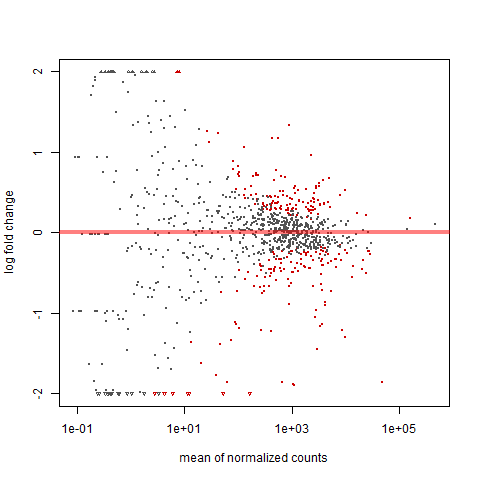

In [10]:
rfunc = robjects.r('function(res) { plotMA(res, ylim=c(-2,2)) }')
plot_notebook(rfunc, res_ordered)

In [11]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [12]:
df = rld_df.transpose()

In [13]:
n_components = 10
pca = PCA(n_components=n_components)
X = pca.fit_transform(df)

In [14]:
np.cumsum(pca.explained_variance_ratio_)

array([0.48836903, 0.73566107, 0.85245316, 0.89653963, 0.92763339,
       0.95525853, 0.97877805, 1.        , 1.        ])

In [15]:
X.shape

(9, 9)

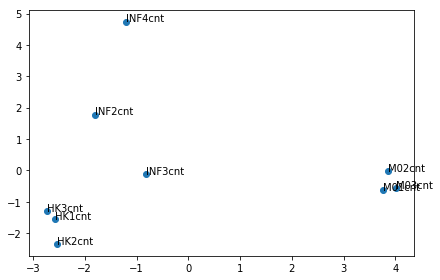

In [16]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])

for i, txt in enumerate(df.index):
    ax.annotate(txt, (X[i, 0], X[i, 1]))
    
plt.tight_layout()